# Hito 2: Tokyo Olympics 2020 Tweets [Versión Extendida]

Integrantes: Felipe Araneda, Alexander Cuevas, Ignacio Díaz, Felipe Maldonado, Millaray Valdivia.

Curso: Introducción a la Minería de Datos CC5206

Fecha: 16 de Noviembre, 2021



##Introducción

Los Juegos Olímpicos son el mayor evento deportivo del mundo, incluyendo múltiples disciplinas y del cual participan atletas procedentes de todo los países y naciones. A mediados del 2021 se realizaron los **"Juegos Olímpicos de Tokyo 2020"**, con un año de retraso debido a la delicada situación sanitaria por la pandemia por COVID-19, y a pesar de que el virus no ha sido completamente erradicado, los avances médicos han abierto la posibilidad de poder realizar los eventos siguiendo protocolos sanitarios y promoviendo el apoyo a los atletas de forma remota.

Este tipo de mega eventos mundiales suelen generar un gran impacto en las redes sociales, donde millones de personas alrededor del mundo comentan sobre el desarrollo del evento, sus expectativas y el desempeño de los distintos atletas. Sin embargo, durante esta version de los juegos las interacciones por estos medios aumentaron de forma considerable respecto a otros años, y es que la situación excepcional del evento ha generado grandes limitaciones para prestar apoyo de forma presencial a los atletas, siendo las redes sociales la única forma de apoyarlos.

Debido a los mencionado anteriormente, para este reporte se presenta una exploración de datos de un dataset de **"Tweets sobre los Juegos Olímpicos de Tokyo 2020"**, el cual fue obtenido mediante la página web [Kaggle](https://www.kaggle.com/gpreda/tokyo-olympics-2020-tweets), y cuyos datos fueron recolectados mediante la API de Twitter, usando la librería *Tweepy* y filtrando para obtener tweets relacionados al tópico **#Tokyo2020**. 

La exploración de datos que se realizará en este reporte incluye un reconocimiento de los datos y sus características, limpieza de las inconsistencias y visualización de los datos. Mediante esta exploración se busca responder preguntas como: cuáles fueron los tópicos más populares, si se pueden agrupar las opiniones similares o cómo cambian estas consideraciones con el desarrollo del evento.

RESVISIÓN 1 DE LAS PREGUNTAS

1) ¿Qué agrupaciones naturales existen en los datos, si es que los hay?

2) ¿las agrupaciones se mantienen al hacer filtro de los tweets entre determinadas horas?

3) ¿son los países que aportan una mayor cantidad de tweets los que definen la tendencia natural observada? 


## Experimentos
En este hito proponemos los siguientes experimentos

1) Aplicar técnicas de clustering al dataset completo, evaluar y
discutir los resultados.

2) Reaplicar la tecnica de clustering utilizada para ditintos hitos relevantes, evaluando y discutiendo los resultados.

3) Reaplicar la tecnica de clustering en los países con mayor cantidad de tweets, evaluando y discutiendo los resultados.

In [ ]:
#@title Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import seaborn as sns

from collections import defaultdict, Counter

from sklearn.feature_extraction.text import CountVectorizer

import gensim
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

# Mejor visualización de las tablas
%load_ext google.colab.data_table

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


# Cargando el dataset del Hito 1

In [ ]:
#@title Cargar el dataset y limpiarlo (Hito 1)
# Cargar el dataset
dataset_1_file = 'tokyo_2020_tweets.csv'
dataset_1_raw = pd.read_csv(dataset_1_file)

# Botamos las filas que tengan algún NaN en ciertas columnas con datos inconsistentes, para que queden así:
dataset_1_raw = dataset_1_raw.dropna(subset=['user_verified', 'source', 'retweets', 'favorites', 'is_retweet'])

# Sin los datos inconsistentes, podemos redefinir los tipos de las columnas
dataset_1_raw['id'] = dataset_1_raw['id'].astype('int64')
dataset_1_raw['user_created'] = dataset_1_raw['user_created'].astype('datetime64')
dataset_1_raw['user_followers'] = dataset_1_raw['user_followers'].astype('int32')
dataset_1_raw['user_friends'] = dataset_1_raw['user_friends'].astype('float64')  # antes era int32
dataset_1_raw['user_favourites'] = dataset_1_raw['user_favourites'].astype('float64')  # antes era int32
dataset_1_raw['user_verified'] = dataset_1_raw['user_verified'].astype('bool')
dataset_1_raw['date'] = dataset_1_raw['date'].astype('datetime64')
dataset_1_raw['retweets'] = dataset_1_raw['retweets'].astype('int32')
dataset_1_raw['favorites'] = dataset_1_raw['favorites'].astype('int32')
dataset_1_raw['is_retweet'] = dataset_1_raw['is_retweet'].astype('bool')

# Ver las primeras filas del dataset
#dataset_1.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# Cargar el nuevo dataset y explorarlo
La exploración es sólo para encontrar incosistencias y qué columnas se necesitan ajustar para unir los datasets. Una vez unidos se hará una exploración más profunda

In [ ]:
#@title Cargar nuevo dataset y limpiarlo (Hito 2)
# Cargar el dataset
dataset_2_file = 'Olympics_Tokyo_tweets.csv'
dataset_2_raw = pd.read_csv(dataset_2_file)

# Ver las primeras filas del dataset
#dataset_2_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,4,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#@title Información general y cantidad de NaN
print(dataset_2_raw.info(), end="\n\n")
dataset_2_raw.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312825 entries, 0 to 312824
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                312825 non-null  object 
 1   text              312821 non-null  object 
 2   user_screen_name  312816 non-null  object 
 3   user_location     227109 non-null  object 
 4   retweet_count     312817 non-null  object 
 5   favorited         312817 non-null  object 
 6   favorite_count    312806 non-null  object 
 7   user_description  284086 non-null  object 
 8   user_created_at   312795 non-null  object 
 9   user_followers    312795 non-null  float64
 10  user_friends      312795 non-null  object 
 11  date              312795 non-null  object 
 12  language          312791 non-null  object 
dtypes: float64(1), object(12)
memory usage: 31.0+ MB
None



id                      0
text                    4
user_screen_name        9
user_location       85716
retweet_count           8
favorited               8
favorite_count         19
user_description    28739
user_created_at        30
user_followers         30
user_friends           30
date                   30
language               34
dtype: int64

In [ ]:
#@title Borrar datos inconsistentes
#dataset_2_raw = dataset_2_raw.dropna(thresh=3) 
dataset_2_raw = dataset_2_raw.dropna(subset=['text', 'user_screen_name', 'retweet_count', 'favorited', 
                                             'favorite_count', 'user_created_at', 'user_followers',
                                             'user_friends', 'date', 'language'])
print(dataset_2_raw.isna().sum())
#dataset_2_raw[dataset_2_raw['text'].isnull()]

id                      0
text                    0
user_screen_name        0
user_location       85708
retweet_count           0
favorited               0
favorite_count          0
user_description    28720
user_created_at         0
user_followers          0
user_friends            0
date                    0
language                0
dtype: int64


In [ ]:
#@title Sin los datos inconsistentes, podemos redefinir los tipos y nombres de las columnas para que calcen con el dataset del hito 1
# Redefiniendo tipos
dataset_2_raw['id'] = dataset_2_raw['id'].astype('int64')
dataset_2_raw['user_created_at'] = dataset_2_raw['user_created_at'].astype('datetime64')
dataset_2_raw['user_followers'] = dataset_2_raw['user_followers'].astype('int32')
dataset_2_raw['user_friends'] = dataset_2_raw['user_friends'].astype('float64')
dataset_2_raw['favorite_count'] = dataset_2_raw['favorite_count'].astype('float64')
dataset_2_raw['date'] = dataset_2_raw['date'].astype('datetime64')
dataset_2_raw['retweet_count'] = dataset_2_raw['retweet_count'].astype('int32')
dataset_2_raw['favorited'] = dataset_2_raw['favorited'].astype('bool')

# Cambiando nombres de las columnas
dataset_2_raw = dataset_2_raw.rename(columns={'user_screen_name': 'user_name',
                      'user_created_at' : 'user_created',
                      'favorite_count' : 'user_favourites',
                      'retweet_count' : 'retweets',
                      'favorited' : 'favorites'})

# Cambiando orden de las columnas
dataset_2_raw = dataset_2_raw[['id', 'user_name', 'user_location', 'user_description', 'user_created',
                               'user_followers', 'user_friends', 'user_favourites', 'date',
                               'text', 'retweets', 'favorites', 'language']]

dataset_2_raw.dtypes

id                           int64
user_name                   object
user_location               object
user_description            object
user_created        datetime64[ns]
user_followers               int32
user_friends               float64
user_favourites            float64
date                datetime64[ns]
text                        object
retweets                     int32
favorites                     bool
language                    object
dtype: object

In [ ]:
#@title Descripción de datos númericos
dataset_2_raw.describe()

,id,user_followers,user_friends,user_favourites,retweets
count,3.127910e+05,3.127910e+05,3.127910e+05,312791.000000,312791.000000
mean,1.420770e+18,8.878135e+04,1.390794e+03,2.633749,0.571599
std,1.176773e+15,1.184711e+06,8.293765e+03,43.370739,20.157928
min,1.418962e+18,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.419787e+18,1.130000e+02,1.790000e+02,0.000000,0.000000
50%,1.420634e+18,4.740000e+02,4.920000e+02,0.000000,0.000000
75%,1.421401e+18,2.048000e+03,1.177000e+03,1.000000,0.000000
max,1.424216e+18,7.806182e+07,2.040639e+06,10053.000000,7396.000000


In [ ]:
#@title Descripción de datos tipo object (en este caso son strings)
dataset_2_raw.describe(include=["object"])

,user_name,user_location,user_description,text,language
count,312791,227083,284071,312791,312791
unique,191105,58663,170437,301862,1
top,Olympics,India,#Olympics - Inspiring people through the Olymp...,@lovinglystar22 @ENHYPEN_members ENHYPEN ON 20...,en
freq,339,4309,345,96,312791


In [ ]:
#@title Descripción de datos en forma de fecha
dataset_2_raw.describe(include=["datetime"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,user_created,date
count,312791,312791
unique,190932,135217
top,2009-06-30 15:23:29,2021-07-26 21:15:34
freq,339,35
first,1970-01-01 00:00:00,2021-07-24 15:52:00
last,2021-08-08 03:44:08,2021-08-08 03:48:38


In [ ]:
#@title Descripción de datos booleanos
dataset_2_raw.describe(include=["bool"])

,favorites
count,312791
unique,2
top,True
freq,247255


## Juntar los dos datasets

Primero, agregamos al segundo dataset una columna con hashtags que podemos extraer del tweet.
Luego, vamos a borrar del dataset 1 (del hito 1) las columnas de 'is_retweet' (porque todos las filas están en falso) y 'favorites'. Éste último lo borraremos de los dos datasets porque no coinciden los tipos (uno es numérico y el otro booleano). Además, borraremos 'language' del segundo dataset porque todos sus valores son 'en' y no está esa columna en el primero.

In [ ]:
#@title Obtener hashtags del segundo dataset

# Función para parsear una lista a string
def list_to_string(l):
  str_i = "["
  str_f = "]"
  for i in l:
    str_i += "'" + str(i) + "'"
  return str_i + str_f

# Extraemos los hashtags de los tweets
dataset_2_raw['hashtags'] = dataset_2_raw.loc[:, 'text']

dataset_2_raw['hashtags'] = dataset_2_raw['hashtags'].apply(lambda text: 
                                          list_to_string([token[1:] for token in text.split() if token.startswith('#')]))
dataset_2_raw['hashtags'] = dataset_2_raw['hashtags'].apply(lambda x: np.nan if x=="[]" else x)

In [ ]:
#@title Botamos columnas que tienen poca o nada variación de datos
dataset_1 = dataset_1_raw.drop(['is_retweet', 'favorites'], axis=1)

dataset_2 = dataset_2_raw.drop(['favorites', 'language'], axis=1)

In [ ]:
#@title Concatenar datasets
frames_dataset = [dataset_1, dataset_2]
dataset = pd.concat(frames_dataset)

# Borrar duplicados según id
dataset = dataset.drop_duplicates(subset=['id'])

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455514 entries, 0 to 312824
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                455514 non-null  int64         
 1   user_name         455514 non-null  object        
 2   user_location     336261 non-null  object        
 3   user_description  419123 non-null  object        
 4   user_created      455514 non-null  datetime64[ns]
 5   user_followers    455514 non-null  int32         
 6   user_friends      455514 non-null  float64       
 7   user_favourites   455514 non-null  float64       
 8   user_verified     159470 non-null  object        
 9   date              455514 non-null  datetime64[ns]
 10  text              455514 non-null  object        
 11  hashtags          214054 non-null  object        
 12  source            159470 non-null  object        
 13  retweets          455514 non-null  int32         
dtypes: d

In [ ]:
#@title Chequeamos valores nulos
print(dataset.isna().sum())

id                       0
user_name                0
user_location       119253
user_description     36391
user_created             0
user_followers           0
user_friends             0
user_favourites          0
user_verified       296044
date                     0
text                     0
hashtags            241460
source              296044
retweets                 0
dtype: int64


In [ ]:
#@title Descripción de datos númericos
dataset.describe()

,id,user_followers,user_friends,user_favourites,retweets
count,4.555140e+05,4.555140e+05,4.555140e+05,4.555140e+05,455514.000000
mean,1.420311e+18,1.030349e+05,1.313691e+03,6.661261e+03,1.245540
std,1.148926e+15,1.280922e+06,7.145873e+03,2.906054e+04,30.538037
min,1.418859e+18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.419535e+18,1.250000e+02,1.810000e+02,0.000000e+00,0.000000
50%,1.419901e+18,5.270000e+02,5.010000e+02,1.000000e+00,0.000000
75%,1.421038e+18,2.411000e+03,1.183000e+03,1.040000e+03,0.000000
max,1.424216e+18,7.806182e+07,2.040639e+06,2.234721e+06,7396.000000


In [ ]:
#@title Descripción de datos en forma de fecha
dataset.describe(include=["datetime"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,user_created,date
count,455514,455514
unique,241406,222430
top,2019-10-26 02:56:57,2021-07-26 16:30:00
freq,762,36
first,1970-01-01 00:00:00,2021-07-24 09:03:12
last,2021-08-08 03:44:08,2021-08-08 03:48:38


In [ ]:
#@title Descripción de datos tipo object (en este caso son strings)
dataset.describe(include=["object"])

,user_name,user_location,user_description,user_verified,text,hashtags,source
count,455514,336261,419123,159470,455514,214054,159470
unique,251167,71351,216675,2,449782,66715,285
top,canadianbestseller.com,India,https://t.co/ZJK4Q3dy6l – Your Prime Discount ...,False,@lovinglystar22 @ENHYPEN_members ENHYPEN ON 20...,['Tokyo2020'],Twitter for Android
freq,755,8462,762,82721,96,32192,52791


## Exploración del nuevo dataset unificado

Text(0.5, 1.0, 'Histograma de caracteres de un tweet')

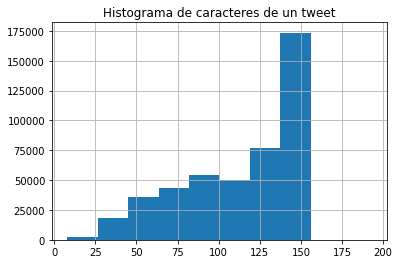

In [ ]:
#@title Histograma de caracteres de un tweet
dataset['text'].str.len().hist()
plt.title('Histograma de caracteres de un tweet')

Text(0.5, 1.0, 'Histograma de cantidad de palabras de un tweet')

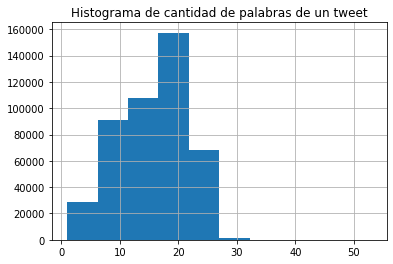

In [ ]:
#@title Histograma de cantidad de palabras de un tweet
dataset['text'].str.split().map(lambda x: len(x)).hist()
plt.title('Histograma de cantidad de palabras de un tweet')

Text(0.5, 1.0, 'Stopwords con mayor frecuencia')

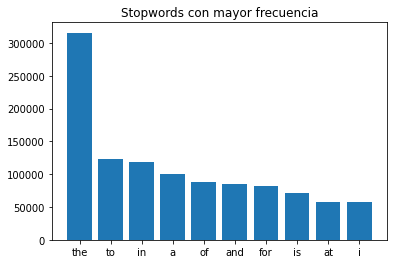

In [ ]:
#@title Gráfico de Stopwords con mayor frecuencia
# Setear stopwords
stop_words=set(stopwords.words('english'))

# Generar corpus (todas las palabras, todas las apariciones)
corpus=[]
tw = dataset['text'].str.split()
tw = tw.values.tolist()
corpus=[word.lower() for i in tw for word in i]

# Generar Diccionario del corpus (tipo bag of words)
dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1

# Seleccionar las n_stopwords palabras que más aparecen
n_stopwords = 10
top=sorted(dic.items(), 
           key=lambda x:x[1],
           reverse=True)[:n_stopwords] 

# Graficar
x,y=zip(*top)
plt.bar(x,y)
plt.title('Stopwords con mayor frecuencia')

Text(0.5, 1.0, 'Palabras con mayor frecuencia (No Stopwords)')

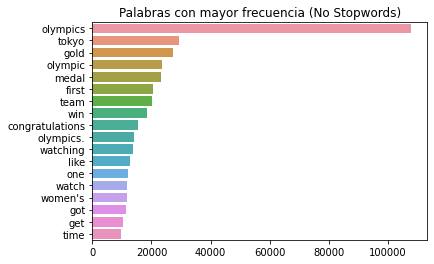

In [ ]:
#@title Palabras con mayor frecuencia (No Stopwords)

# Palabras o símbolos que se consideran como stopwords
banned = ['I', '', '-', '#', '!', '?', 'The', '&amp;', '|']

# Contar las más comunes
counter=Counter(corpus)
most=counter.most_common()

# Generar listas con las palabras que más aparecen y su conteo
word_list, count_list= [], []
for word,count in most[:80]:
    if (word not in stop_words 
        and not word.startswith('#')  # Evitar hashtags
        and not word.startswith('@')  # Evitar menciones
        and not word in banned):
        word_list.append(word)
        count_list.append(count)

# Graficar
sns.barplot(x=count_list,y=word_list)
plt.title('Palabras con mayor frecuencia (No Stopwords)')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_te

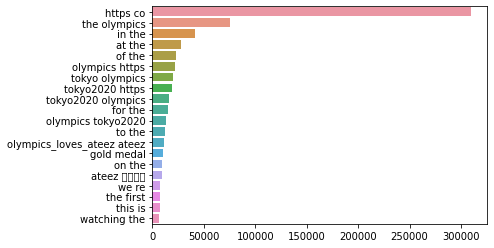

In [ ]:
#@title BiGramas con mayor frecuencia (No Stopwords)

# Función que genera los n-gramas
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

# Obtener los bigramas
top_n_bigrams=get_top_ngram(dataset['text'],2)[:20]

# Graficar
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_te

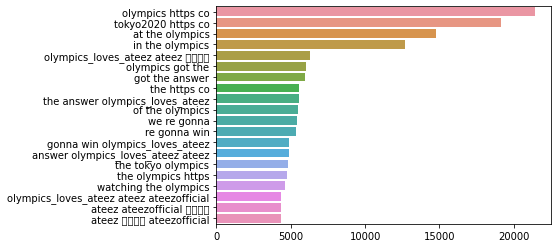

In [ ]:
#@title TriGramas con mayor frecuencia (No Stopwords)

# Obtener los trigramas
top_tri_grams=get_top_ngram(dataset['text'],n=3)
#Graficar
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

### Topic Modeling

In [ ]:
#@ Topic Modeling
# Función que preprocesa un dataframe para obtener un corpus con Stemming y Lemmatization
def preprocess(df, stop_words):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for tweet in df['text']:
        words=[w for w in word_tokenize(tweet.lower()) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

# Obtener el corpus
new_corpus=preprocess(dataset, stop_words)

# Obtener diccionario del corpus
new_dic=gensim.corpora.Dictionary(new_corpus)

# Obtener Bag of words
bow_corpus = [new_dic.doc2bow(doc) for doc in new_corpus]

In [ ]:
# Modelo de Topic Modeling # DEMORA MÁS DE 30 MIN.
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = new_dic,                                    
                                   passes = 10,
                                   workers = 2)

# Mostrar los tópicos
lda_model.show_topics()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 57 kB/s 
     |████████████████████████████████| 11.3 MB 49.3 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=616f7078b3e9baea057fe25abdb31611753fb5cfa9b974310fac618df2d18481
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pand

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += 

[(0,
  '0.088*"olympics" + 0.054*"http" + 0.009*"n\'t" + 0.008*"sport" + 0.008*"like" + 0.007*"watching" + 0.006*"..." + 0.006*"watch" + 0.006*"get" + 0.005*"one"'),
 (1,
  '0.066*"http" + 0.044*"olympics" + 0.016*"tokyo" + 0.014*"team" + 0.013*"woman" + 0.011*"tokyo2020" + 0.009*"men" + 0.008*"final" + 0.007*"usa" + 0.007*"olympic"'),
 (2,
  '0.041*"olympics" + 0.041*"http" + 0.022*"ateezofficial" + 0.022*"ateez" + 0.015*"olympics_loves_ateez" + 0.014*"에이티즈" + 0.014*"enhypen" + 0.009*"got" + 0.007*"2020" + 0.007*"gon"'),
 (3,
  '0.068*"http" + 0.043*"olympics" + 0.033*"gold" + 0.030*"medal" + 0.012*"india" + 0.011*"win" + 0.011*"tokyo" + 0.010*"tokyo2020" + 0.008*"congratulation" + 0.008*"proud"')]

In [ ]:
!pip install pandas==1.2.0
# upgrade pandas para correr la siguiente celda

In [ ]:
#@ Visualización del Topic Modeling
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Generar visualización
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, new_dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.134901  0.214407       1        1  32.726960
1     -0.089498 -0.087612       2        1  29.504965
3     -0.056736 -0.167902       3        1  22.450504
2      0.281135  0.041107       4        1  15.317571, topic_info=                        Term          Freq  ...  logprob  loglift
11                      gold  36170.000000  ...  30.0000  30.0000
93                     medal  32920.000000  ...  29.0000  29.0000
287857         ateezofficial  16541.000000  ...  28.0000  28.0000
200683                 ateez  16207.000000  ...  27.0000  27.0000
331583  olympics_loves_ateez  11180.000000  ...  26.0000  26.0000
...                      ...           ...  ...      ...      ...
132                      win   4840.112846  ...  -5.0385   0.3187
18                     tokyo   3712.031529  ...  -5.3039  -0.4633
253                  athlete   2597.052169  ...  -5.6611   0.2903
31                       via   1874.202489  ...  -5.9872   0.7099
199                   summer   1529.070839  ...  -6.1908   1.2348

[217 rows x 6 columns], token_table=        Topic      Freq    Term
term                           
384         1  0.212903     're
384         4  0.787001     're
1228        1  0.999726     've
301         1  0.712997     ...
301         2  0.096689     ...
...       ...       ...     ...
171         1  0.875860    year
171         3  0.124099    year
2206        1  0.999793     yes
319552      4  0.999737  エイティーズ
318338      4  0.999951    에이티즈

[245 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

### Wordcloud

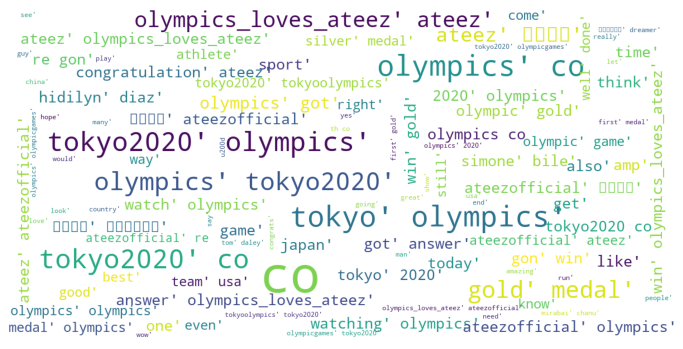

In [ ]:
#@title Wordcloud
from wordcloud import WordCloud, STOPWORDS

# Obtener Stopwords
sw = set(STOPWORDS)

# Agregar Stopwords
sw.update(['http', 'http\'' ])

# Función que genera el gráfico de wordcloud
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=sw,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')    
    plt.imshow(wordcloud)
    plt.show()
    

# Generar gráfico
show_wordcloud(new_corpus)

## Análisis de Sentimiento

Text(0.5, 1.0, 'Histograma de polaridad de un tweet')

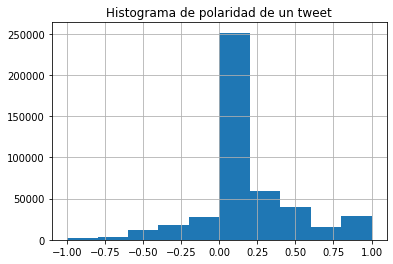

In [ ]:
#@title Análisis de Sentimiento
from textblob import TextBlob

# Función que obtiene la polaridad de un texto entre [-1, 1]
def polarity(text):
    return TextBlob(text).sentiment.polarity
    
# Agregar columna con el score de polaridad para cada tweet
dataset['polarity_score']=dataset['text'].apply(lambda x : polarity(x))

# Graficar Histograma de polaridad de un tweet
dataset['polarity_score'].hist()
plt.title('Histograma de polaridad de un tweet')

Text(0.5, 1.0, 'Cantidad de tweets por cada sentimiento')

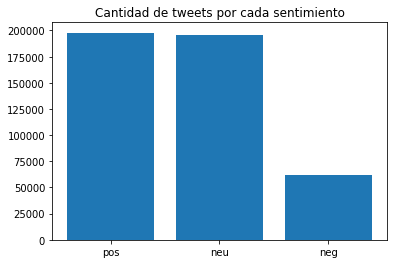

In [ ]:
#@title Visualización de Cantida de tweets por cada sentimiento
# Función que asigna sentimeinto según score de polaridad
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
# Agregar columna con el sentimiento del tweet según la polaridad
dataset['polarity']=dataset['polarity_score'].map(lambda x: sentiment(x))

# Graficar
plt.bar(dataset.polarity.value_counts().index, dataset.polarity.value_counts())
plt.title('Cantidad de tweets por cada sentimiento')

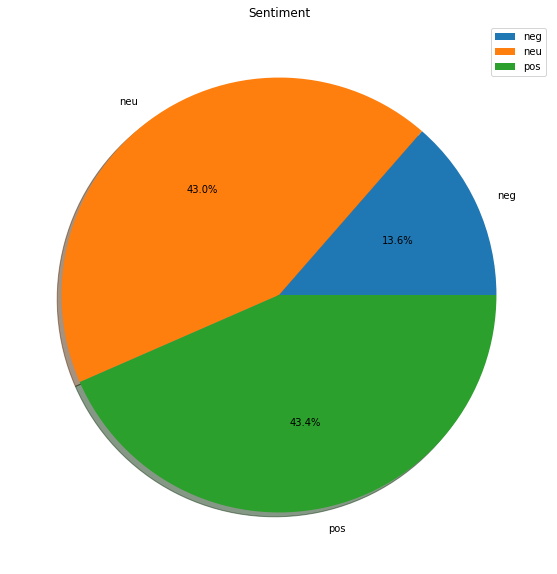

In [ ]:
#@ Visualización de Frecuencia de los sentimientos en los tweets
# Agrupar columna de sentimiento y contar
polarity_df = dataset[['polarity']].groupby(['polarity']).size().reset_index(name='count')

# graficar
plot1 = polarity_df.plot.pie(y='count', labels=polarity_df['polarity'],
                             title='Sentiment Frecuency', figsize=(10,10),
                             ylabel='', autopct='%1.1f%%', shadow=True, startangle=0)

## Exploración geográfica

In [ ]:
#@title Instalación de librerías necesarias
!pip install geopandas
!pip install pycountry
import geopandas as gpd
import regex as re
import pycountry
import matplotlib.colors as pltcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

regions = gpd.read_file("World_Countries.shp")

In [ ]:
#@title Generación de información por país
def has_country(country, location, loop=False):
  group = re.search("(?<![A-z])"+ country + "(?![A-z])", location)
  if group:
    return True
  return False

country_list = []
for index, row in regions.iterrows():
  country_list.append(row["COUNTRY"])

country_dict = {}

for index, row in dataset.iterrows():
  location = str(row["user_location"])
  for country in country_list:
    if has_country(country, location):
      if country in country_dict:
        country_dict[country]["count"] += 1
        country_dict[country]["polarity_score"] += row["polarity_score"]
      else:
        country_dict[country] = {"count": 1, "index": country_list.index(country), "polarity_score": row["polarity_score"]}
      break

In [ ]:
#@title Agregar información por país al mapa
regions["COUNT"] = 0
regions["POLARITY_AVERAGE"] = 0.0
for key in country_dict.keys():
  regions.at[country_dict[key]["index"], "COUNT"] = country_dict[key]["count"]
  regions.at[country_dict[key]["index"], "POLARITY_AVERAGE"] = country_dict[key]["polarity_score"] / country_dict[key]["count"]

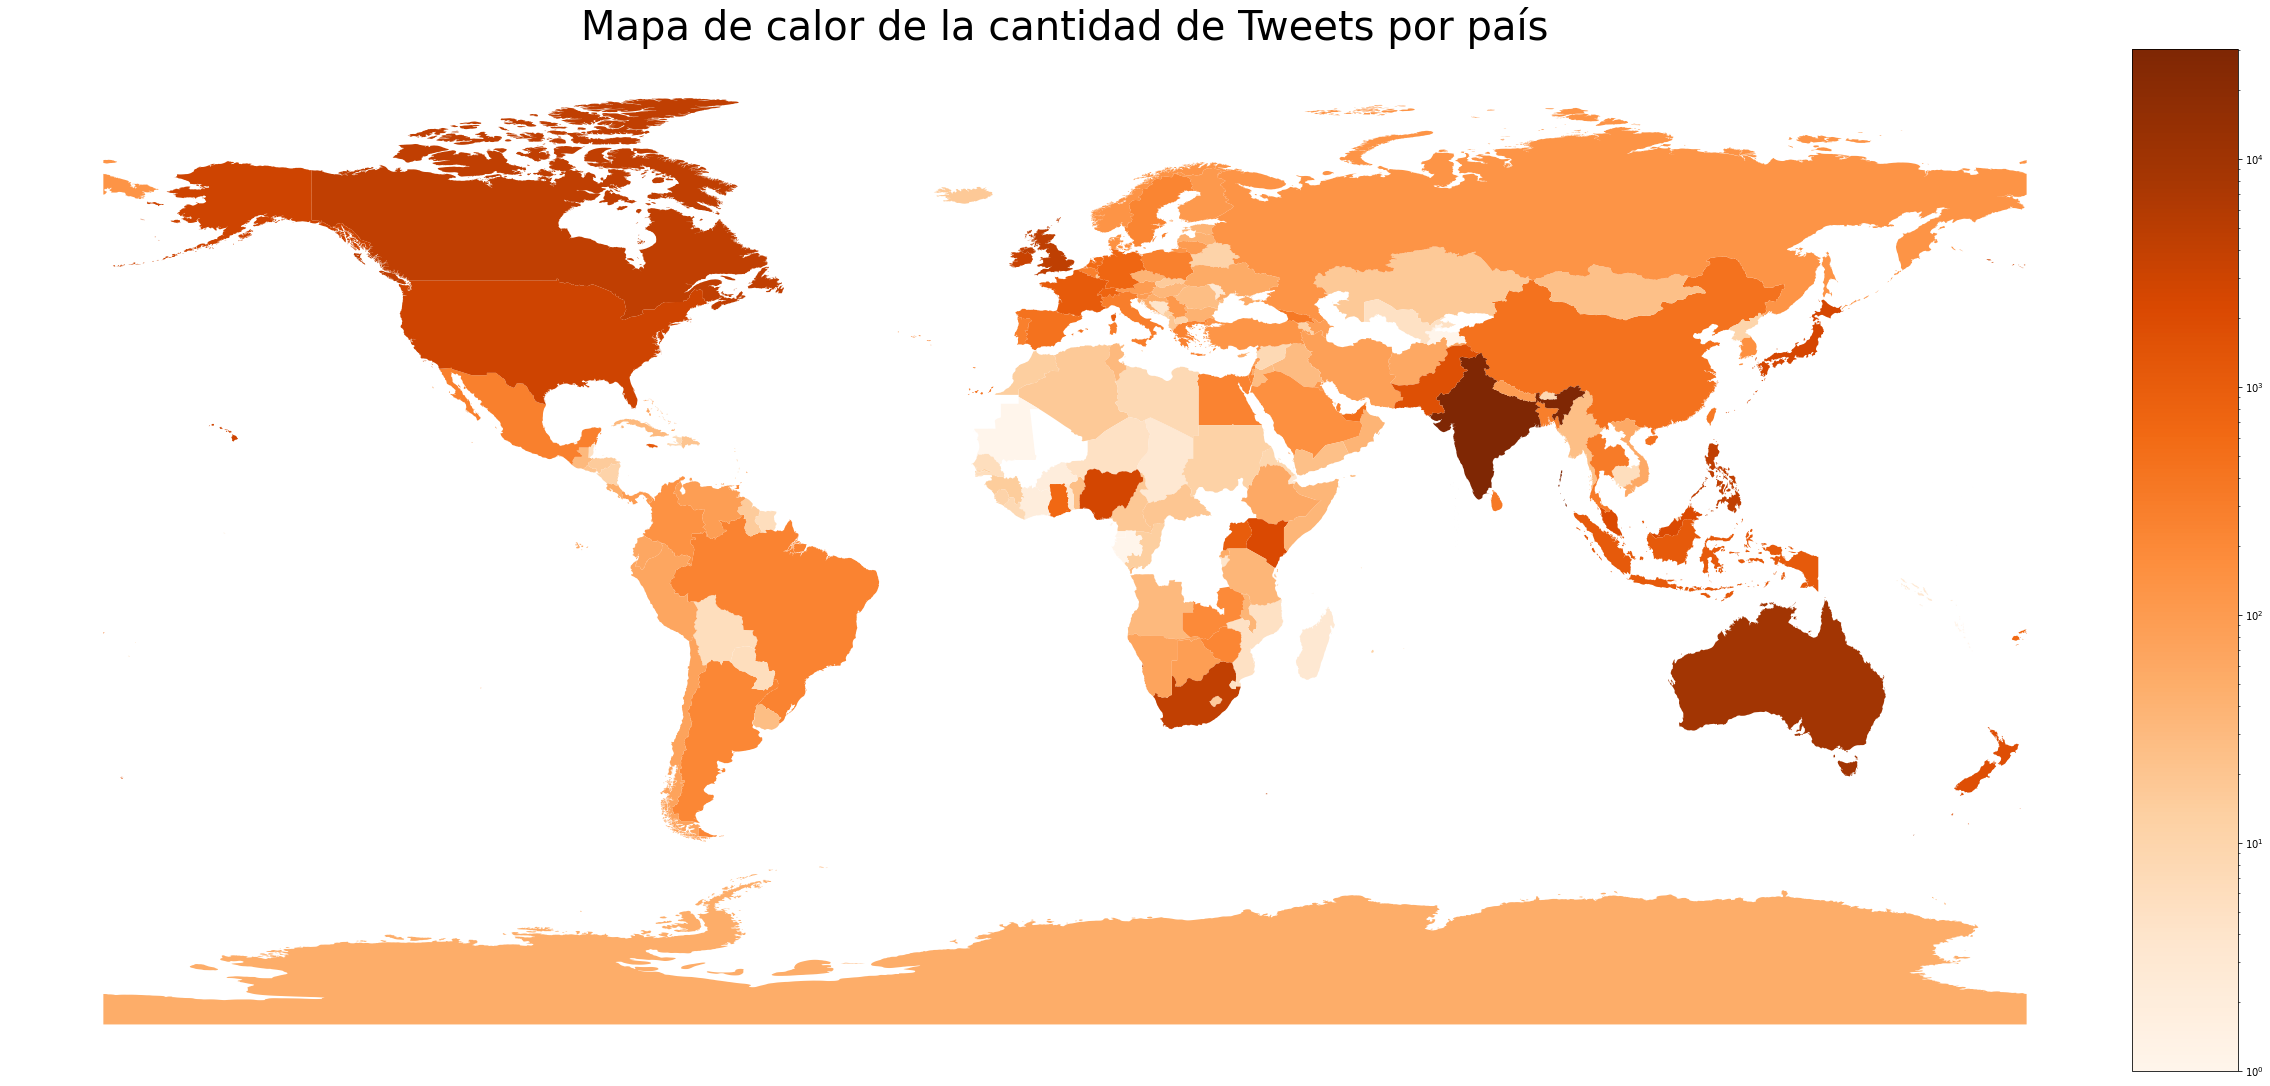

In [ ]:
#@title Mapa de calor de la cantidad de Tweets por país
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Mapa de calor de la cantidad de Tweets por país', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = 1, max(regions["COUNT"])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = regions.plot("COUNT", cmap=color, figsize=(30,20), ax=ax, norm=pltcolors.LogNorm(vmin=vmin, vmax=vmax), legend=True, cax=cax)
plt.show()

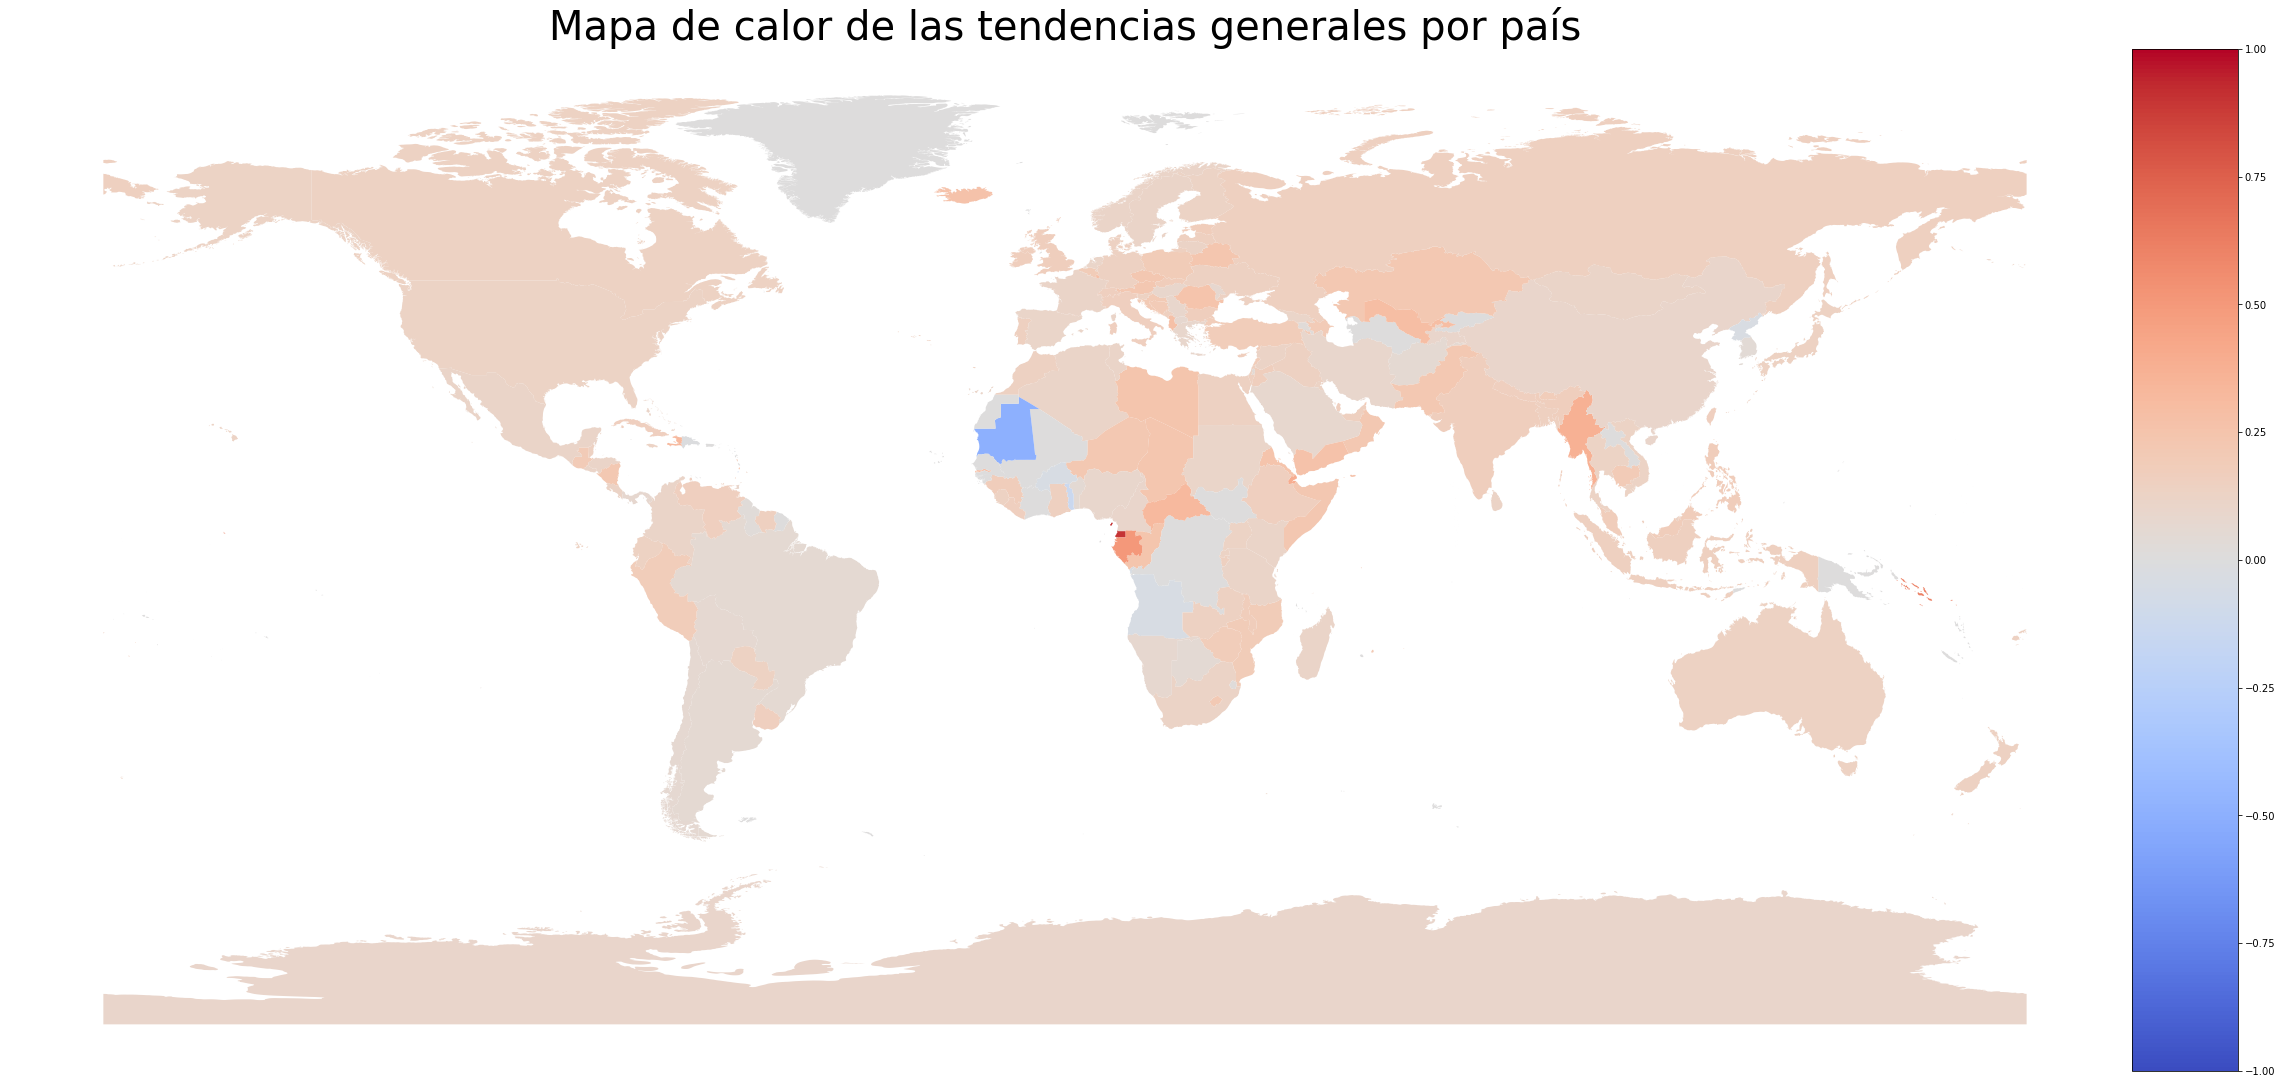

In [ ]:
#@title Mapa de calor de las tendencias generales por país
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Mapa de calor de las tendencias generales por país', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = plt.cm.coolwarm
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = regions.plot("POLARITY_AVERAGE", cmap=color, figsize=(30,20), ax=ax, norm=pltcolors.Normalize(vmin=-1, vmax=1), legend=True, cax=cax)
plt.show()

### Word2Vector

In [ ]:
#Importar paquetes
import re  
from time import time  
from collections import defaultdict 
import string 
import multiprocessing
import os
import requests

# word2vec
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

# visualizaciones
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets


In [ ]:
#Armar nueva variable con solo los textos
text = dataset['text']

from collections import Counter

#Limpiar puntuaciones y separar por tokens.
punctuation = string.punctuation + "«»“”‘’…—"
stopwords = pd.read_csv(
    'https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt'
).values
stopwords = Counter(stopwords.flatten().tolist())


def simple_tokenizer(doc, lower=False):
    if lower:
        tokenized_doc = doc.translate(str.maketrans(
            '', '', punctuation)).lower().split()

    tokenized_doc = doc.translate(str.maketrans('', '', punctuation)).split()

    tokenized_doc = [
        token for token in tokenized_doc if token.lower() not in stopwords
    ]
    return tokenized_doc

cleaned_text= [simple_tokenizer(doc) for doc in text.values]

In [ ]:
print("Ejemplo de algun tweet: {}".format(cleaned_text[30]))

Ejemplo de algun tweet: ['TeamIndia', 'Tokyo2020', 'Boxing', 'Mens', 'Welter', 'weight', '6369kg', 'Round', 'of', '32', 'Results', 'A', 'brave', 'officialvkyadav', 'bows', 'httpstcoez0JesBLD3']


In [ ]:
#EXTRACION DE FRASES
phrases = Phrases(cleaned_text, min_count=100, progress_per=5000)

In [ ]:
phrases.vocab

defaultdict(int,
            {b'Let': 562,
             b'the': 279281,
             b'Let_the': 112,
             b'party': 309,
             b'the_party': 38,
             b'begin': 547,
             b'party_begin': 1,
             b'Tokyo2020': 114799,
             b'begin_Tokyo2020': 13,
             b'Congratulations': 10101,
             b'Congratulations_Tokyo2020': 104,
             b'httpstco8OFKMs9ukq': 1,
             b'Tokyo2020_httpstco8OFKMs9ukq': 1,
             b'Big': 921,
             b'Breaking': 257,
             b'Big_Breaking': 6,
             b'Now': 2301,
             b'Breaking_Now': 3,
             b'Tokyo': 30811,
             b'Now_Tokyo': 3,
             b'Olympic': 23940,
             b'Tokyo_Olympic': 787,
             b'Update': 365,
             b'Olympic_Update': 32,
             b'Japan': 7286,
             b'Update_Japan': 6,
             b'won': 8655,
             b'Japan_won': 75,
             b'his': 8553,
             b'won_his': 95,
            

In [ ]:
#Ahora, usamos Phraser para re-tokenizamos el corpus con los bigramas encontrados. Es decir, juntamos los tokens separados que detectamos como frases.
bigram = Phraser(phrases)
sentences = bigram[cleaned_text]

In [ ]:
#DEFINIR EL MODELO
tweets_w2v = Word2Vec(min_count=10,
                      window=4,
                      size=200,
                      sample=6e-5,
                      alpha=0.03,
                      min_alpha=0.0007,
                      negative=20,
                      workers=multiprocessing.cpu_count())

In [ ]:
#CONSTRUIR EL VOCABULARIO
tweets_w2v.build_vocab(sentences, progress_per=10000)

In [ ]:
#ENTRENAR EL MODELO
t = time()
tweets_w2v.train(sentences, total_examples=tweets_w2v.corpus_count, epochs=15, report_delay=10)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 11.11 mins


In [ ]:
#Indicar que no se entrenara más el modelo
tweets_w2v.init_sims(replace=True)

In [ ]:
#Algunas aplicaciones del w2v
tweets_w2v.wv.most_similar(positive=["SimoneBiles"])

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[('Simone', 0.7366538047790527),
 ('Simone_Biles', 0.7012126445770264),
 ('USAGym', 0.6936110258102417),
 ('mykaylaskinner', 0.6747704148292542),
 ('USAGym_TeamUSA', 0.6189979314804077),
 ('biles', 0.6091804504394531),
 ('Simones', 0.6011719703674316),
 ('MentalHealth', 0.6006196737289429),
 ('Biles', 0.6005527973175049),
 ('HenryCejudo', 0.5992542505264282)]

In [ ]:
tweets_w2v.wv.most_similar(positive=["Tokyo"])

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[('Tokyo_2020', 0.7384036779403687),
 ('Toky', 0.6735348701477051),
 ('2020', 0.5681636333465576),
 ('Toyko', 0.5633240938186646),
 ('Olympic', 0.5471658706665039),
 ('Tok', 0.5353396534919739),
 ('httpstcoXXD1qW2eaI', 0.5221904516220093),
 ('Games', 0.512744128704071),
 ('on_Saturday', 0.4916054606437683),
 ('from_AP', 0.4913058876991272)]

In [ ]:
tweets_w2v.wv.most_similar(positive=["olympic"])

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[('olympics', 0.5031154155731201),
 ('Olympic', 0.4638444781303406),
 ('tokyo', 0.4567892551422119),
 ('olympian', 0.4369816780090332),
 ('tokyo_olympics', 0.43296027183532715),
 ('asian', 0.38814711570739746),
 ('japan', 0.38413888216018677),
 ('philippines', 0.37229233980178833),
 ('Olym', 0.3691471219062805),
 ('an_Olympic', 0.35445988178253174)]

In [ ]:
tweets_w2v.wv.most_similar(positive=["ateez"])

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[('5sos', 0.725165605545044),
 ('skz', 0.7182042598724365),
 ('atz', 0.7156656980514526),
 ('Ateez', 0.692416787147522),
 ('dreamers', 0.683932900428772),
 ('bts', 0.6744837760925293),
 ('dj', 0.6672013401985168),
 ('blackpink', 0.6612707376480103),
 ('enhypen', 0.6559739112854004),
 ('songs', 0.6510551571846008)]

### Doc2Vec

In [ ]:
import pickle
import pandas as pd
import numpy
import re
import os
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

In [ ]:
#Acomodar el documento para aplicarlo a doc2vec
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0 
for em in dataset['text'].values:    
  all_content_train.append(LabeledSentence1(em,[j]))
  j+=1
print('Number of texts processed: ', j)

Number of texts processed:  455514


In [ ]:
#Creacion del modelo d2v
d2v_model = Doc2Vec(all_content_train, size = 300, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
#Entrenamiento del modelo d2v
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [ ]:
data_f = d2v_model.docvecs.doctag_syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:322: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:322: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will 

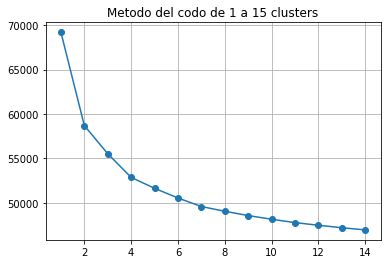

In [ ]:
#Aplicar el metodo del codo para determinar el numero de cluster a utilizar en k-means
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt

sse = []

clusters = list(range(1, 15))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(data_f)
    sse.append(kmeans.inertia_)

#Grafico del metodo del nodo
plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 15 clusters")
plt.grid(True)
plt.show()

In [ ]:
#Aplicacion k-means con 4 clusters
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100) 
X = kmeans_model.fit(data_f)
labels=kmeans_model.labels_.tolist()

l = kmeans_model.fit_predict(data_f)
pca = PCA(n_components=2).fit(data_f)
datapoint = pca.transform(data_f)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:322: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:322: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

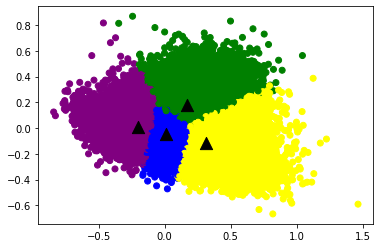

In [ ]:
#Graficar k-means
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [ ]:
#Ahora se extraera el tweet más cercano a cada centroide
cluster_0 = d2v_model.docvecs.most_similar(positive=[centroids[0]],topn=10)

cluster_1 = d2v_model.docvecs.most_similar(positive=[centroids[1]],topn=10)

cluster_2 = d2v_model.docvecs.most_similar(positive=[centroids[2]],topn=10)

cluster_3 = d2v_model.docvecs.most_similar(positive=[centroids[3]],topn=10)

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link f

In [ ]:
#Top 10 tweets más cercanos al centroide 0
for i in range(0,10):
  print('tweet', i+1,":", all_content_train[cluster_0[i][0]].words)

tweet 1 : @CHOIJONGHOSGF OLYMPICS GOT THE ANSWER
#OLYMPICS_LOVES_ATEEZ 
@ATEEZofficial #ATEEZ #에이티즈 
#エイティーズ
tweet 2 : Answer also played at the Olympics??!???😭😭😭
tweet 3 : @ATEEZsystem @ATEEZofficial WE'RE GONNA WIN
OLYMPICS GOT THE ANSWER 
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ @ATEEZofficial #에이티즈
#エイティーズ #DREAMERS
tweet 4 : @cutiiejjong WE'RE GONNA WIN
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 @ATEEZofficial
tweet 5 : The Olympics are totally worth me missing my bedtime!!!! 🇺🇸🇺🇸🇺🇸🥇🥇🥇🇺🇸🇺🇸🇺🇸
tweet 6 : WE'RE GONNA WIN
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 @ATEEZofficial
tweet 7 : @atcczs @ATEEZofficial WE'RE GONNA WIN
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 @ATEEZofficial
tweet 8 : Tokyo's Olympics Game Today &amp; Tomorrow!!!!!🇬🇧🇬🇧🇬🇧🇬🇧🇬🇧🌞🌞🌞🌞
tweet 9 : @oneeezwrld @ATEEZofficial WE'RE GONNA WIN
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 @ATEEZofficial
tweet 10 : FOUR ATEEZ SONGS PLAYED AT THE OLYMPICS OMG


In [ ]:
#Top 10 tweets más cercanos al centroide 1
for i in range(0,10):
  print('tweet', i+1,":", all_content_train[cluster_1[i][0]].words)

tweet 1 : The Olympics are totally worth me missing my bedtime!!!! 🇺🇸🇺🇸🇺🇸🥇🥇🥇🇺🇸🇺🇸🇺🇸
tweet 2 : @cutiiejjong WE'RE GONNA WIN
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 @ATEEZofficial
tweet 3 : WE'RE GONNA WIN
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 @ATEEZofficial
tweet 4 : THEY PLAYED ASAP AT THE OLYMPICS ???? WHAT
tweet 5 : @Tokyo2020 @Olympics GO NESTHY!!!!!! GO PHILIPPINES!!!!! 🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭
tweet 6 : @CHOIJONGHOSGF OLYMPICS GOT THE ANSWER
#OLYMPICS_LOVES_ATEEZ 
@ATEEZofficial #ATEEZ #에이티즈 
#エイティーズ
tweet 7 : @Olympics 👩‍⚖️👩‍⚖️👩‍⚖️👩‍⚖️👩‍⚖️🤝🇯🇵🇯🇵🇯🇵🇯🇵🇯🇵🇯🇵🇯🇵

Robbing everyone
tweet 8 : @ShawnMendes are you watching the Olympics???
tweet 9 : @ATEEZsystem @ATEEZofficial WE'RE GONNA WIN
OLYMPICS GOT THE ANSWER 
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ @ATEEZofficial #에이티즈
#エイティーズ #DREAMERS
tweet 10 : WALAY EATING OLYMPICS DRA CHARAUGHT


In [ ]:
#Top 10 tweets más cercanos al centroide 2
for i in range(0,10):
  print('tweet', i+1,":", all_content_train[cluster_2[i][0]].words)

tweet 1 : Come on Talha #Tokyo2020
tweet 2 : OMG NESTY PETECIO GRABE KA!!! CONGRATULATIONS!!! 🇵🇭🇵🇭🇵🇭 

#PHI #Olympics #boxing #Tokyo2020
tweet 3 : FINAAAAAAL!
#Tokyo2020
tweet 4 : These rims are so trash #Tokyo2020 #FRAUSA
tweet 5 : give a "yeet" for keet #Tokyo2020
tweet 6 : Sixth.🥇✔️🇨🇳🏋🏻‍♂️ #Tokyo2020
tweet 7 : Congratulations  #ManikaBatra #Tokyo2020 #IndiaAtTokyo2020
tweet 8 : Germany scores boom #Tokyo2020
tweet 9 : I don't even know what a Tashkent is

#Tokyo2020
tweet 10 : Get in, Zii Jia! GET IN!!!! 🇲🇾🇲🇾🇲🇾🇲🇾🇲🇾

#Badminton #Tokyo2020 #GanbatteMalaysia


In [ ]:
#Top 10 tweets más cercanos al centroide 3
for i in range(0,10):
  print('tweet', i+1,":", all_content_train[cluster_3[i][0]].words)

tweet 1 : The Olympics are totally worth me missing my bedtime!!!! 🇺🇸🇺🇸🇺🇸🥇🥇🥇🇺🇸🇺🇸🇺🇸
tweet 2 : @Olympics What?!?!?!?!😲😲😲 That is incredible!!!!! What a lil G!!!!!!
tweet 3 : @cutiiejjong WE'RE GONNA WIN
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 @ATEEZofficial
tweet 4 : #TeamGB are doing amazing at the #Olympics 👏🏽👏🏽👏🏽
tweet 5 : @Olympics 👩‍⚖️👩‍⚖️👩‍⚖️👩‍⚖️👩‍⚖️🤝🇯🇵🇯🇵🇯🇵🇯🇵🇯🇵🇯🇵🇯🇵

Robbing everyone
tweet 6 : @dellysngie CONGRATULATIONS ATEEZ
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 #エイティーズ
@ATEEZofficial @ATEEZofficialjp #DREAMERS
tweet 7 : BRO 15 N 17 IN OLYMPICS????
tweet 8 : WE'RE GONNA WIN
#OLYMPICS_LOVES_ATEEZ 
#ATEEZ #에이티즈 @ATEEZofficial
tweet 9 : @Olympics CONGRATS HIDILYN DIAZ!! WEST PHILIPPINE SEA IS OURS!!!!!🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭🇵🇭
tweet 10 : I JUST FINISHED MY GOOGLE MEET AND BUTTER ON OLYMPICS SJSJSJDHHSSHGS


# Participación

Felipe Araneda: Introducción, preguntas y problemas, preparación y presentación de la primera presentación (PPT). Revisión de preguntas, reporte, segunda presentación.

Alexander Cuevas: Exploraciones iniciales y visualizaciones. Edición del reporte. Exploración geográfica.

Ignacio Díaz: Introducción. Carga, limpieza y unión de ambos de set de datos, exploraciones iniciales, y aplicación de topic modeling, wordcloud y análisis de sentimiento. Tokenización, eliminación de stopwords y símbolos, visualizaciones.

Felipe Maldonado: Redacción de la introducción, así como preparación, presentación y edición de la primera presentación. Aplicación de Word2Vector.

Millaray Valdivia: Visualizaciones y preparación de ambas presentaciones.